In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x113c79940>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
from gfcat_utils import *

In [5]:
import numpy as np
from astropy.io import fits as pyfits
from astropy import wcs as pywcs
from astropy.visualization import simple_norm, ZScaleInterval

In [6]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [7]:
fn = '/Users/cm/GFCAT/data/e42907/e42907-nd-full.fits.gz'

In [8]:
image,flagmap,edgemap,wcs,tranges,exptimes=read_image(fn)
image[np.where(np.isinf(image))]=0 # because it pops out with inf values... IDK

In [12]:
lc = parse_lightcurves("/Users/cm/GFCAT/data/e42907/e42907-nd-30s-photom.csv")

In [26]:
lc[0].keys()

dict_keys(['counts', 'edge_flags', 'mask_flags', 'cps', 'cps_err', 'xcenter', 'ycenter', 'ra', 'dec'])

In [85]:
x = np.array([source['xcenter'] for source in lc])
y = np.array([source['ycenter'] for source in lc])
cps = np.array([np.nanmean(source['cps']) for source in lc])

In [75]:
def is_variable(lc,sigma=3):
    if any(lc['edge_flags']):
        return False#continue # skip if there is any data near the detector edge
    if any(lc['mask_flags']): #if all(lc['mask_flags'][ix]):
        return False#continue  # skip if there is any data covered by the hotspot mask
    ix = np.where((lc['cps']!=0) & (np.isfinite(lc['cps'])))[0]
    #if expt['t1'][ix[-1]] - expt['t0'][ix[0]]<500:
    #    return False#continue # skip if there are not at least 8 min of exposure on target
        # This duration was chosen to eliminate a relatively high number of false positives
        # in shorter visits. It is approx. 1/3rd duration of a full MIS-depth visit.
    if len(ix)/(ix[-1]+1-ix[0])<0.75:
        return False#continue # skip if more than a quarter of the bins are unobserved
        # NOTE: It's technically possible to have 30-second integrated flux on a source
        #  be exactly equal to zero. But it's low probability and has no meaningful effect
        #  on the variability search.
    sort_ix = np.argsort(lc["cps"][ix])
    if len(np.where(lc["mask_flags"][ix][sort_ix][-10:])[0]) >= 5:
        return False#continue # more than half of the brightest points are flagged by the hotspot mask
    # The following check has been moved into the cluster analysis because the bright stars
    # also generate false detections / variables nearby
    #if (lc["cps"][ix][sort_ix[1]] > 170):# and (lc["cps"][ix][sort_ix[-1]]>300):
    #    continue # skip if the whole visit is >14.5 AB Mag in NUV
    # The chance of one outlier low point over 50M visits is not small, generates a lot of false positives
    # The chance of two outlier low points within a visit is small.
    # So use the second-lowest point in the visit as the benchmark.
    second_min = np.sort((lc['cps']+lc['cps_err']*sigma)[ix])[1]
    outlier_ix = np.where((lc['cps'] - lc['cps_err'] * sigma)[ix] > second_min)[0]
    if len(outlier_ix) < 3:
        return False#continue # skip if there are not 3 significant outliers using the dumbest heuristic
    if is_spiky(lc):
        return False#continue  # skip: multiple spiky peaks, most likely contaminated by an artifact
    peak_ix, _ = signal.find_peaks(lc['cps'], prominence=3 * lc['cps_err'], distance=4)
    if len(peak_ix):
        if len(peak_ix) > 3:
            return False#continue  # skip multiple spiky peaks, most likely contaminated by an artifact
        # NOTE: This test for spiky behavior is a little slower than I'd like, but workable.
        #  And it does a more thorough job than the faster / simpler `is_spikey()` above.
    ad = stats.anderson(lc['cps'][ix])  # standard test of variability
    if ad.statistic <= ad.critical_values[2]:
        return False#continue  # failed the anderson-darling test at 5%
        # NOTE: AD is the gold standard variability test, but it's relatively slow, so it
        #  has been pushed to the end of the screening heuristics
    # Whatever remains is a candidate variable
    return True

In [109]:
def anderson_darling_variable(cps):
    ix = np.isfinite(cps)
    ad = stats.anderson(cps[ix])
    return ad.statistic > ad.critical_values[2]

In [136]:
%time varmask = [is_variable(source) for source in lc]
print(any(varmask))
%time varmask_ad = [anderson_darling_variable(source['cps']) for source in lc]

CPU times: user 48.4 ms, sys: 1.58 ms, total: 50 ms
Wall time: 48.6 ms


True

CPU times: user 367 ms, sys: 1.16 ms, total: 369 ms
Wall time: 368 ms


In [137]:
varmag = np.array([(np.nanmax(source['cps'])-np.nanmin(source['cps']))/np.nanmean(source['cps']) for source in lc])

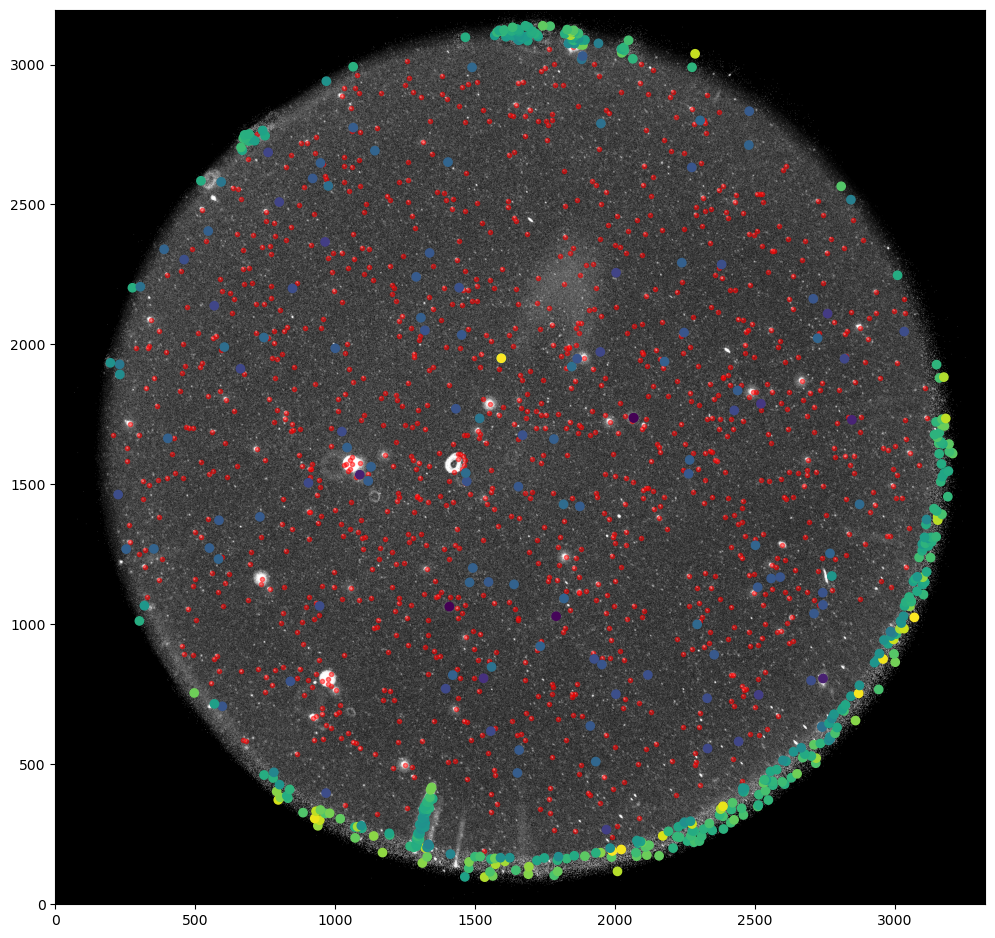

In [155]:
plt.figure(figsize=(12,12))
plt.imshow(ZScaleInterval()(image),cmap="Greys_r",origin="lower")
plt.scatter(x,y,c='r',marker='.',alpha=0.5)
plt.scatter(x[np.where(varmask_ad)],y[np.where(varmask_ad)],marker='o',alpha=1,
            cmap='viridis',c=np.log(varmag[varmask_ad]))
plt.scatter(x[np.where(varmask)],y[np.where(varmask)],marker='o',alpha=1,
            cmap='viridis',c=np.log(varmag[varmask]))

#plt.xlim([1500,1700])
#plt.ylim([1800,2000])

In [23]:
def plt_qa_stamp(image,edgemap,flagmap,pos,boxsz=100):
    #pos = (1927.4492801503593 , 3341.396819357223)
    x1,x2,y1,y2 = (int(pos[0]-boxsz),int(pos[0]+boxsz),
                   int(pos[1]-boxsz),int(pos[1]+boxsz))
    norm = simple_norm(image[x1:x2,y1:y2],'log')
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(ZScaleInterval()(image[x1:x2,y1:y2]),cmap="Greys_r",origin="lower")
    ax.imshow(1/edgemap[x1:x2,y1:y2], origin="lower", cmap="Reds_r",alpha=1)
    ax.imshow(1/flagmap[x1:x2,y1:y2], origin="lower", cmap="Blues_r",alpha=1)
    ax.plot(boxsz,boxsz,markersize=30,color='y',lw=10, marker='o', fillstyle='none')#marker='o')
    ax.set_xticks([])
    ax.set_yticks([])

In [20]:
edir = 'e10766'
fn = f'/Users/cm/Downloads/{edir}-nd-full.fits'

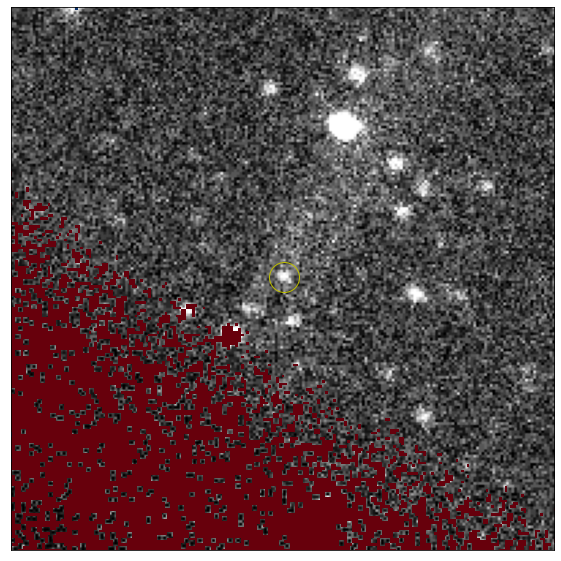

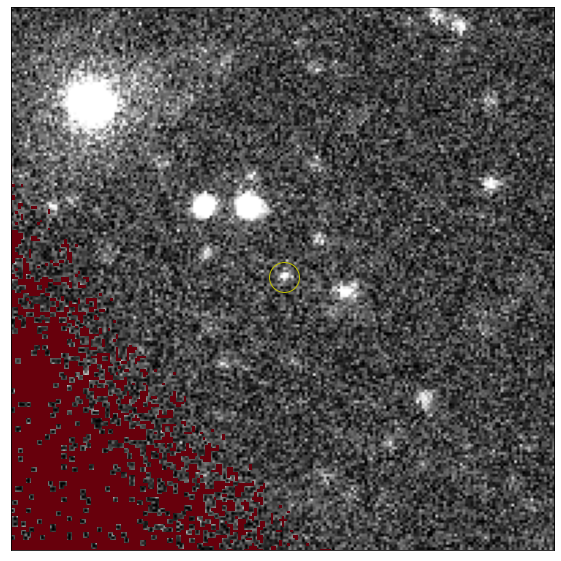

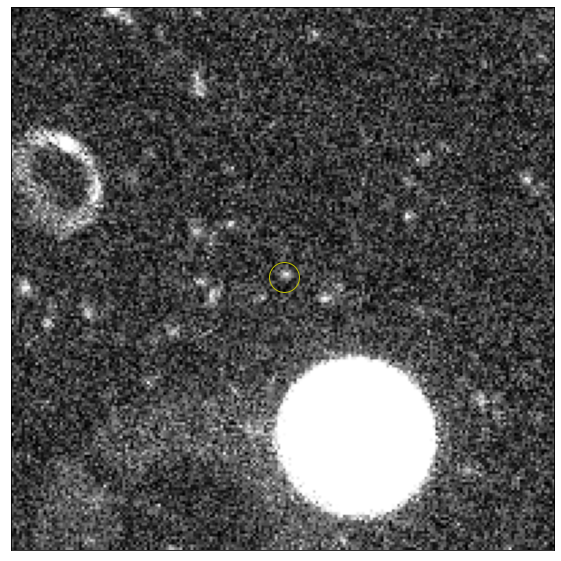

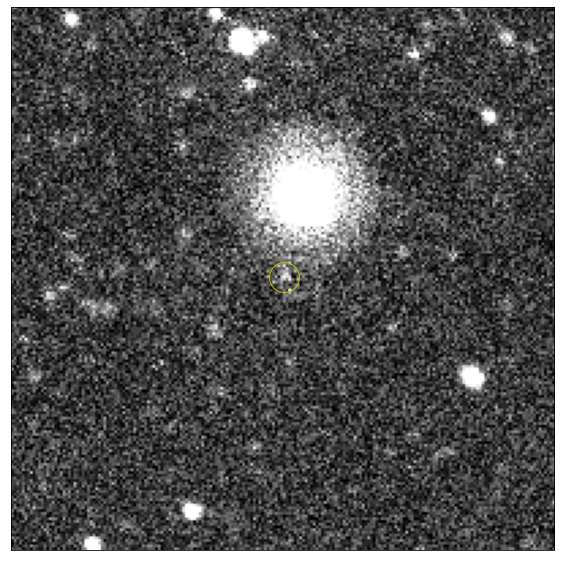

In [22]:
plt_qa_stamp(image,edgemap,flagmap,(452.2189277363829 , 2048.09636268542))#,boxsz=500)
plt_qa_stamp(image,edgemap,flagmap,(760.285722350015 , 1746.278575407254))#,boxsz=500)
plt_qa_stamp(image,edgemap,flagmap,(1194.8025564748332 , 2105.610502080094))#,boxsz=500)
plt_qa_stamp(image,edgemap,flagmap,(1927.4492801503593 , 3341.396819357223))#,boxsz=500)